In [1]:
from torch.utils.data import DataLoader, random_split,TensorDataset
from torch.utils.tensorboard import SummaryWriter
# Importing the libraries
import torch
#from torchviz import make_dot
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import NN_classes
from torchvision import datasets, transforms
from datetime import datetime
import training_methods


In [2]:
torch.cuda.is_available()

False

In [5]:
executions = ["Network_Line_Out_N_101_N_102_cac1","Network_Line_Out_N_102_N_104_cac1","Network_Line_Out_N_101_N_105_cac1","Network_Line_Out_N_102_N_104_cac1","Network_Line_Out_N_102_N_106_cac1","Network_Line_Out_N_103_N_109_cac1"]
#executions = ["Network_Line_Out_N_101_N_102_cac1"]

#executions = ["Network_Full_Generation_Full","Network_Line_In_N_101_N_102_cac1","Network_Line_In_N_101_N_103_cac1","Network_Line_In_N_101_N_105_cac1"]
sc = "sc01"
period = "2030"

In [6]:
dfs_in = dict()
dfs_out = dict()
folder = "RTS_24"
for execution in executions:
    #Read the data from desired execution
    df_in_e = pd.read_csv(f"Data/{folder}/input_f_{sc}_{execution}_{period}.csv",header=[0,1])
    df_out_e = pd.read_csv(f"Data/{folder}/output_f_{sc}_{execution}_{period}.csv",header=[0,1])

    #Drop the first row(s) because its useless 
    df_in_e = df_in_e.drop([0])
    if folder == "RTS_24":
        df_out_e = df_out_e.drop([0])
    elif folder == "RTS_24_AC":
        df_out_e = df_out_e.drop([0,1])
    print(f"Data/input_f_{sc}_{execution}_{period}.csv")
    
    #Split the real and imaginary part the input data: 
    df_in_e_r = df_in_e["Value_R"]
    df_in_e_i = df_in_e["Value_I"]
    
    #And order the variables: 
    
    
    
    print(len(df_in_e_r.columns)+ len(df_in_e_i.columns))
    
    df_in_e_c = pd.concat([df_in_e_r,df_in_e_i],axis=1)
    df_out_e = df_out_e["Value"]
    for col in df_out_e.columns: 
        df_out_e[col] = df_out_e[col].astype(float)
    dfs_in[execution] = df_in_e_c
    dfs_out[execution] = df_out_e


Data/input_f_sc01_Network_Line_Out_N_101_N_102_cac1_2030.csv
1312
Data/input_f_sc01_Network_Line_Out_N_102_N_104_cac1_2030.csv
1312
Data/input_f_sc01_Network_Line_Out_N_101_N_105_cac1_2030.csv
1312
Data/input_f_sc01_Network_Line_Out_N_102_N_104_cac1_2030.csv
1312
Data/input_f_sc01_Network_Line_Out_N_102_N_106_cac1_2030.csv
1312
Data/input_f_sc01_Network_Line_Out_N_103_N_109_cac1_2030.csv
1312


In [7]:
ts_in  = dict()
ts_out = dict()

ts_in["train"] = dict()
ts_in["test"]  = dict()
ts_in["val"]  = dict()

ts_out["train"]= dict()
ts_out["test"] = dict()
ts_out["val"]= dict()


#Test size as fraction of full dataset, validation size as fraction of training data set
test_size,validation_size = 0.2,0.2

for execution in executions: 
    #Convert input dataframes numpy arrays sum the columns of the output: 
    np_in = dfs_in[execution].to_numpy()
    np_out = dfs_out[execution].to_numpy().sum(axis=1)
    
    #We don't normalize the separate runs, but will do it afterward, all together

    #Convert to torch tensors
    t_in = torch.from_numpy(np_in)
    t_out = torch.from_numpy(np_out)

    #And split into train, validation, and test set:
    train_in,ts_in["test"][execution],train_out,ts_out["test"][execution]= train_test_split(t_in,t_out,test_size=test_size,shuffle=False)
    ts_in["train"][execution],ts_in["val"][execution],ts_out["train"][execution],ts_out["val"][execution] = train_test_split(train_in,train_out,test_size=validation_size,shuffle=False)

In [8]:
#concatenate all the training and testing sets to a single tensor, and normalize: 
first = True
for execution in executions:
    if first: 
        tr_in = ts_in["train"][execution]
        tr_out = ts_out["train"][execution]
        te_in = ts_in["test"][execution]
        te_out = ts_out["test"][execution]
        val_in = ts_in["val"][execution]
        val_out = ts_out["val"][execution]
        first = False
    else: 
        tr_in = torch.cat((tr_in,ts_in["train"][execution]))
        tr_out= torch.cat((tr_out,ts_out["train"][execution]))
        te_in = torch.cat((te_in,ts_in["test"][execution]))
        te_out= torch.cat((te_out,ts_out["test"][execution]))
        val_in = torch.cat((val_in,ts_in["val"][execution]))
        val_out= torch.cat((val_out,ts_out["val"][execution]))
        
        
maxs= torch.cat((tr_in,te_in,val_in)).abs().max(dim = 0).values
# maxs_te = te_in.abs().max(dim = 0).values
tr_in = torch.nan_to_num(tr_in/maxs)
te_in = torch.nan_to_num(te_in/maxs)
val_in = torch.nan_to_num(val_in/maxs)

In [9]:
n_ts_in  = dict()

n_ts_in["train"] = dict()
n_ts_in["test"]  = dict()
n_ts_in["val"]  = dict()

for execution in executions: 
    n_ts_in["train"][execution] = torch.nan_to_num(ts_in["train"][execution]/maxs)
    n_ts_in["test"][execution] = torch.nan_to_num(ts_in["test"][execution]/maxs)
    n_ts_in["val"][execution] = torch.nan_to_num(ts_in["val"][execution]/maxs)

In [10]:
train = TensorDataset(tr_in.float(), tr_out.float())
validation = TensorDataset(val_in, val_out)

training_loader = DataLoader(train,batch_size=32)
validation_loader = DataLoader(train,batch_size=32)


In [49]:
learning_rates = [0.01*4**i for i in range(4)]
loss_fn = torch.nn.MSELoss()
nbs_e = [2,4,8]
i=0
results = pd.DataFrame()
for nb_e in nbs_e:
    for lr in learning_rates:
        m_d = dict()

        m_d["sl"] = NN_classes.ObjectiveEstimator_ANN_Single_layer(input_size=tr_in.shape[1],output_size=1)
        m_d["3h"] = NN_classes.ObjectiveEstimator_ANN_3hidden_layer(input_size=tr_in.shape[1],hidden_size1=int(tr_in.shape[1]/4),hidden_size2=int(tr_in.shape[1]/16),hidden_size3=int(tr_in.shape[1]/64),output_size=1)


        for m_name in m_d:
            m = m_d[m_name]
            optimizer = torch.optim.Adam(m.parameters(), lr=lr)
            train_loss = training_methods.train_multiple_epochs(nb_e,m,training_loader,validation_loader,loss_fn,optimizer,m_name)
            
            test_predictions = m(te_in.float())
            test_loss = loss_fn(test_predictions,te_out)
            train_predictions = m(tr_in.float())
            train_loss = loss_fn(train_predictions,tr_out)
            
            r = pd.DataFrame({"Model": m_name,"Epochs": nb_e,"Lr":lr, "Tr_l":train_loss.item(),"Te_l":test_loss.item()},index = [i]
            )
            i+=1
            results = pd.concat([results,r])
        

EPOCH 1:
  batch 1 loss: 0.4808466339111328
  batch 101 loss: 3.9140544447302816
  batch 201 loss: 1.7130151024460794
  batch 301 loss: 0.6783644327521324
  batch 401 loss: 0.6253941395878791
  batch 501 loss: 0.2895984887331724
  batch 601 loss: 0.1671581783797592
  batch 701 loss: 0.08890095236711204
  batch 801 loss: 0.1477286569075659
  batch 901 loss: 0.10265894392970949
  batch 1001 loss: 0.019355966607108713


C:\Workdir\Programs\Miniconda\envs\jr23\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Workdir\Programs\Miniconda\envs\jr23\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([4])) that is different to the input size (torch.Size([4, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


LOSS train 0.019355966607108713 valid 3.95135760307312
EPOCH 2:
  batch 1 loss: 0.008500305414199829
  batch 101 loss: 0.04793586740735918
  batch 201 loss: 0.031291165300644935
  batch 301 loss: 0.02166490328963846
  batch 401 loss: 0.04485066747991368
  batch 501 loss: 0.01794984140433371
  batch 601 loss: 0.034255422619171444
  batch 701 loss: 0.04711033577565104
  batch 801 loss: 0.07993934328318573
  batch 901 loss: 0.04499069046229124
  batch 1001 loss: 0.02603263978147879
LOSS train 0.02603263978147879 valid 3.8955087661743164


C:\Workdir\Programs\Miniconda\envs\jr23\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([10488])) that is different to the input size (torch.Size([10488, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


EPOCH 1:
  batch 1 loss: 0.5047174072265626
  batch 101 loss: 6.5499325665831565
  batch 201 loss: 0.4376942977262661
  batch 301 loss: 0.033452451386256146
  batch 401 loss: 0.1905786937265657
  batch 501 loss: 0.03687682198069524
  batch 601 loss: 0.050204033288173376
  batch 701 loss: 0.06304576861148234
  batch 801 loss: 0.6135004765354097
  batch 901 loss: 0.2933079294068739
  batch 1001 loss: 0.05199463279743213
LOSS train 0.05199463279743213 valid 3.7469770908355713
EPOCH 2:
  batch 1 loss: 0.0013370612263679505
  batch 101 loss: 0.03787773148098495
  batch 201 loss: 0.10887664567679167
  batch 301 loss: 0.038657416318601465
  batch 401 loss: 0.3593461203738116
  batch 501 loss: 0.05611602072021924
  batch 601 loss: 0.0727459300897317
  batch 701 loss: 0.08674444074276835
  batch 801 loss: 0.5398490991862491
  batch 901 loss: 0.08533523302525282
  batch 1001 loss: 0.023485966389998794
LOSS train 0.023485966389998794 valid 3.6823384761810303
EPOCH 1:
  batch 1 loss: 0.46555816650

  batch 401 loss: 0.05378525264095515
  batch 501 loss: 0.020172401282470675
  batch 601 loss: 0.048108673715032635
  batch 701 loss: 0.0467384966998361
  batch 801 loss: 0.11066845989087597
  batch 901 loss: 0.04537907757330686
  batch 1001 loss: 0.021923284311778844
LOSS train 0.021923284311778844 valid 3.9744744300842285
EPOCH 1:
  batch 1 loss: 0.46873069763183595
  batch 101 loss: 4.319261511564255
  batch 201 loss: 0.27664346027188
  batch 301 loss: 0.03447177627007477
  batch 401 loss: 0.16416093832580372
  batch 501 loss: 0.043997973166406155
  batch 601 loss: 0.042509000197751445
  batch 701 loss: 0.07482115617545787
  batch 801 loss: 0.7319168318039737
  batch 901 loss: 0.10418367812409997
  batch 1001 loss: 0.04914840347017162
LOSS train 0.04914840347017162 valid 3.974503755569458
EPOCH 2:
  batch 1 loss: 0.0018115429580211639
  batch 101 loss: 0.03674841858141008
  batch 201 loss: 0.06444751193688716
  batch 301 loss: 0.02946833033056464
  batch 401 loss: 0.1781067834456917

  batch 601 loss: 2.4287029618024825
  batch 701 loss: 3.0425941514968873
  batch 801 loss: 3.1002687764167787
  batch 901 loss: 3.9517746496200563
  batch 1001 loss: 2.530954757928848
LOSS train 2.530954757928848 valid 3.0499534606933594
EPOCH 2:
  batch 1 loss: 0.03181617021560669
  batch 101 loss: 2.5447273445129395
  batch 201 loss: 3.3554027378559113
  batch 301 loss: 2.3059470975399017
  batch 401 loss: 2.9716196668148043
  batch 501 loss: 2.791324318647385
  batch 601 loss: 2.4242157447338104
  batch 701 loss: 2.9250802671909333
  batch 801 loss: 3.0083009070158004
  batch 901 loss: 3.7466279578208925
  batch 1001 loss: 2.5609968292713163
LOSS train 2.5609968292713163 valid 3.247371196746826
EPOCH 3:
  batch 1 loss: 0.022440967559814454
  batch 101 loss: 2.482841749191284
  batch 201 loss: 3.2424973237514494
  batch 301 loss: 2.316059809923172
  batch 401 loss: 2.8528396391868593
  batch 501 loss: 2.785937284231186
  batch 601 loss: 2.4553697085380555
  batch 701 loss: 2.9332796

LOSS train 0.024669692376628517 valid 4.108790874481201
EPOCH 7:
  batch 1 loss: 0.006849660873413086
  batch 101 loss: 0.05434956596523989
  batch 201 loss: 0.03596405640244484
  batch 301 loss: 0.020881190734216945
  batch 401 loss: 0.05591354054864496
  batch 501 loss: 0.021894433656707405
  batch 601 loss: 0.04198232606053352
  batch 701 loss: 0.042780724633485076
  batch 801 loss: 0.09104353792965413
  batch 901 loss: 0.04356769630685449
  batch 1001 loss: 0.02487525444244966
LOSS train 0.02487525444244966 valid 4.06896448135376
EPOCH 8:
  batch 1 loss: 0.005806527137756348
  batch 101 loss: 0.0504627425695071
  batch 201 loss: 0.036787798220757395
  batch 301 loss: 0.021051961991470306
  batch 401 loss: 0.055970871101599186
  batch 501 loss: 0.022103378060273828
  batch 601 loss: 0.04008748156484217
  batch 701 loss: 0.04131142813013867
  batch 801 loss: 0.08695968168554828
  batch 901 loss: 0.04417190247215331
  batch 1001 loss: 0.024940978598315268
LOSS train 0.0249409785983152

LOSS train 0.08449962634476833 valid 4.34503173828125
EPOCH 8:
  batch 1 loss: 0.0051615524291992185
  batch 101 loss: 0.07646693438640796
  batch 201 loss: 0.08229106021812185
  batch 301 loss: 0.06568094410467892
  batch 401 loss: 0.1953231842396781
  batch 501 loss: 0.07440745685016736
  batch 601 loss: 0.05078942950349301
  batch 701 loss: 0.08750015011319193
  batch 801 loss: 0.2907425358449109
  batch 901 loss: 0.15639740461483598
  batch 1001 loss: 0.08014746369677596
LOSS train 0.08014746369677596 valid 4.319479465484619
EPOCH 1:
  batch 1 loss: 0.461282958984375
  batch 101 loss: 16.34450750157237
  batch 201 loss: 0.2144525778386742
  batch 301 loss: 0.04063709376845509
  batch 401 loss: 0.30678221189882604
  batch 501 loss: 0.09405938786105253
  batch 601 loss: 0.07230133591074264
  batch 701 loss: 0.1472294491302455
  batch 801 loss: 0.33352535967016594
  batch 901 loss: 0.19279743898659946
  batch 1001 loss: 0.05386129686259664
LOSS train 0.05386129686259664 valid 3.610919

  batch 101 loss: 11797.539998268187
  batch 201 loss: 3.155270057916641
  batch 301 loss: 2.2347846746444704
  batch 401 loss: 3.0615558081865313
  batch 501 loss: 2.8165529322624208
  batch 601 loss: 2.5018982595205306
  batch 701 loss: 3.0428545480966567
  batch 801 loss: 3.0837019479274748
  batch 901 loss: 3.867468537092209
  batch 1001 loss: 2.550157918334007
LOSS train 2.550157918334007 valid 3.003542184829712
EPOCH 2:
  batch 1 loss: 0.023484544754028322
  batch 101 loss: 2.4897468596696855
  batch 201 loss: 3.25125117123127
  batch 301 loss: 2.3117117935419085
  batch 401 loss: 2.84400160074234
  batch 501 loss: 2.774747458100319
  batch 601 loss: 2.4203374713659285
  batch 701 loss: 2.913242597579956
  batch 801 loss: 3.0277395260334017
  batch 901 loss: 3.7772894102334975
  batch 1001 loss: 2.581390620470047
LOSS train 2.581390620470047 valid 3.316047430038452
EPOCH 3:
  batch 1 loss: 0.022427020072937013
  batch 101 loss: 2.5467533761262895
  batch 201 loss: 3.3229398602247

Exception in thread Thread-185:
Traceback (most recent call last):
  File "C:\Workdir\Programs\Miniconda\envs\jr23\lib\threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "C:\Workdir\Programs\Miniconda\envs\jr23\lib\site-packages\tensorboard\summary\writer\event_file_writer.py", line 244, in run
    self._run()
  File "C:\Workdir\Programs\Miniconda\envs\jr23\lib\site-packages\tensorboard\summary\writer\event_file_writer.py", line 275, in _run
    self._record_writer.write(data)
  File "C:\Workdir\Programs\Miniconda\envs\jr23\lib\site-packages\tensorboard\summary\writer\record_writer.py", line 40, in write
    self._writer.write(header + header_crc + data + footer_crc)
  File "C:\Workdir\Programs\Miniconda\envs\jr23\lib\site-packages\tensorboard\compat\tensorflow_stub\io\gfile.py", line 773, in write
    self.fs.append(self.filename, file_content, self.binary_mode)
  File "C:\Workdir\Programs\Miniconda\envs\jr23\lib\site-packages\tensorboard\compat\tensorflow_stub\io\gfi

  batch 801 loss: 13.80372010976076
  batch 901 loss: 10.262496636509896
  batch 1001 loss: 3.6587807289883494


PermissionError: [Errno 13] Permission denied: b'trained_models/sl_20230613_165450\\events.out.tfevents.1686668090.SET-L-ME-T20003.21632.180'

In [123]:
col = "Model"
val = "Te_l"
index = "Epochs"
lr = 0.16
lr_filter = results["Lr"]== lr
results_p = pd.pivot_table(results[lr_filter],index = index,columns =col,values = val)
results_p


Model,3h,sl
Epochs,,
2,4.800205,11.384189
4,5.640344,15.935939
8,7.490673,12.699363


<Axes: xlabel='Epochs'>

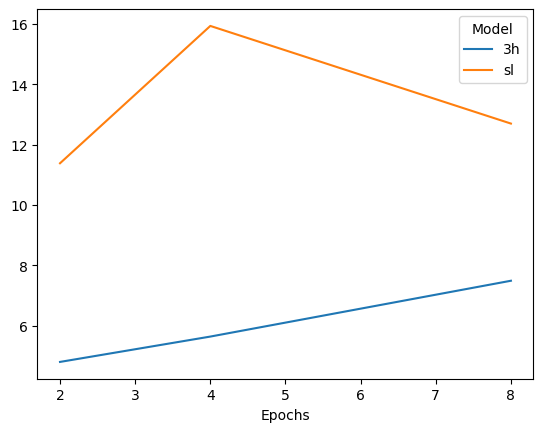

In [124]:
results_p.plot()

Model  Lr  
3h     0.01    Axes(0.125,0.11;0.775x0.77)
       0.04    Axes(0.125,0.11;0.775x0.77)
       0.16    Axes(0.125,0.11;0.775x0.77)
       0.64    Axes(0.125,0.11;0.775x0.77)
sl     0.01    Axes(0.125,0.11;0.775x0.77)
       0.04    Axes(0.125,0.11;0.775x0.77)
       0.16    Axes(0.125,0.11;0.775x0.77)
       0.64    Axes(0.125,0.11;0.775x0.77)
dtype: object

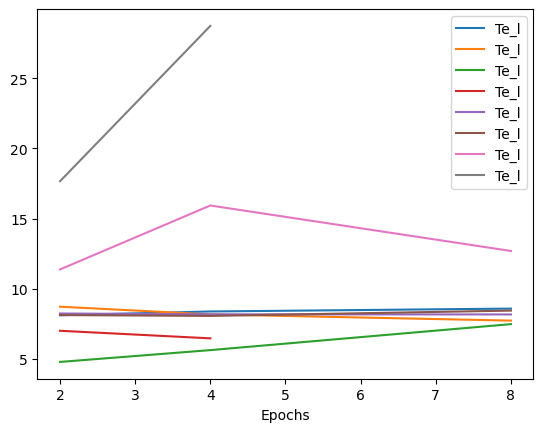

In [108]:
fig, axs = plt.subplots(1)

results.groupby(by=["Model","Lr"]).plot(x="Epochs", y="Te_l", legend ="Model",subplots=False,ax=axs)

In [8]:
model_1 = NN_classes.ObjectiveEstimator_ANN_Single_layer(input_size=tr_in.shape[1],output_size=1)
model_2 = NN_classes.ObjectiveEstimator_ANN_3hidden_layer(input_size=tr_in.shape[1],hidden_size1=int(tr_in.shape[1]/4),hidden_size2=int(tr_in.shape[1]/16),hidden_size3=int(tr_in.shape[1]/64),output_size=1)
#NN_classes.train_and_get_loss(model_1,tr_in,tr_out,300,0.1,True)
#NN_classes.train_and_get_loss(model_2,tr_in,tr_out,1000,0.002,True)
loss_fn = torch.nn.MSELoss()
optimizer_2 = torch.optim.Adam(model_2.parameters(), lr=0.01)

training_methods.train_multiple_epochs(3,model_2,training_loader,validation_loader,loss_fn,optimizer_2,"test")

EPOCH 1:
  batch 1 loss: 5.014025497436523
  batch 11 loss: 29.254683828353883
  batch 21 loss: 9.781697273254395
  batch 31 loss: 5.710300117731094
  batch 41 loss: 2.2088923335075377
  batch 51 loss: 1.2521924138069154
  batch 61 loss: 0.8476809918880462
  batch 71 loss: 0.7145717918872834
  batch 81 loss: 1.0648151367902756
  batch 91 loss: 1.1764125168323516
  batch 101 loss: 1.3930197179317474
  batch 111 loss: 1.0598139673471452
  batch 121 loss: 0.7119953095912933
  batch 131 loss: 0.3969255819916725
  batch 141 loss: 0.15161588788032532
  batch 151 loss: 0.05081282779574394
  batch 161 loss: 0.057492995355278256
  batch 171 loss: 0.03174470094963908
  batch 181 loss: 0.17944115824066104
  batch 191 loss: 0.3891167588531971
  batch 201 loss: 0.3343778468668461
  batch 211 loss: 0.07881808113306761
  batch 221 loss: 0.07209362019784749
  batch 231 loss: 0.02389383951667696
  batch 241 loss: 0.00927038157824427
  batch 251 loss: 0.019217728823423385
  batch 261 loss: 0.00565625006

C:\Workdir\Programs\Miniconda\envs\jr23\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Workdir\Programs\Miniconda\envs\jr23\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([4])) that is different to the input size (torch.Size([4, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


LOSS train 0.08661296275677159 valid 3.904047966003418
EPOCH 2:
  batch 1 loss: 0.02090938538312912
  batch 11 loss: 0.09438872532919049
  batch 21 loss: 0.07301831487566232
  batch 31 loss: 0.0687874548137188
  batch 41 loss: 0.04335537906736135
  batch 51 loss: 0.01343401710037142
  batch 61 loss: 0.012673099082894624
  batch 71 loss: 0.0033747910347301513
  batch 81 loss: 0.0032376127783209085
  batch 91 loss: 0.0050210075220093135
  batch 101 loss: 0.04086588271893561
  batch 111 loss: 0.10871437033638358
  batch 121 loss: 0.05554338982328773
  batch 131 loss: 0.018714431207627058
  batch 141 loss: 0.014958285726606846
  batch 151 loss: 0.009049979958217592
  batch 161 loss: 0.09049982214346527
  batch 171 loss: 0.05634141012560576
  batch 181 loss: 0.05383996358141303
  batch 191 loss: 0.15448499694466591
  batch 201 loss: 0.07344593983143569
  batch 211 loss: 0.07399076828733087
  batch 221 loss: 0.04730522809550166
  batch 231 loss: 0.029957952070981266
  batch 241 loss: 0.01059

  batch 21 loss: 0.022157061472535135
  batch 31 loss: 0.013926070462912322
  batch 41 loss: 0.005900491602369584
  batch 51 loss: 0.001963285333476961
  batch 61 loss: 0.0028009775327518583
  batch 71 loss: 0.0011555030068848282
  batch 81 loss: 0.0011010069923941047
  batch 91 loss: 0.002496063862054143
  batch 101 loss: 0.02865811815718189
  batch 111 loss: 0.06418613004498183
  batch 121 loss: 0.030088707990944385
  batch 131 loss: 0.029109309846535324
  batch 141 loss: 0.015604101470671594
  batch 151 loss: 0.0036773117855773306
  batch 161 loss: 0.02082880727830343
  batch 171 loss: 0.01753796208940912
  batch 181 loss: 0.03250947707565501
  batch 191 loss: 0.018273625546135007
  batch 201 loss: 0.012113772204611451
  batch 211 loss: 0.019446222530677914
  batch 221 loss: 0.00906983760651201
  batch 231 loss: 0.004608506805379875
  batch 241 loss: 0.0028406723809894173
  batch 251 loss: 0.0006927587557584048
  batch 261 loss: 0.0010074058183818125
  batch 271 loss: 0.012067234006

  batch 21 loss: 0.0526805798523128
  batch 31 loss: 0.031799664907157424
  batch 41 loss: 0.044718948751688005
  batch 51 loss: 0.01078072835225612
  batch 61 loss: 0.004209500132128596
  batch 71 loss: 0.004889599315356463
  batch 81 loss: 0.0024053539149463178
  batch 91 loss: 0.004378106415970251
  batch 101 loss: 0.00997951765311882
  batch 111 loss: 0.00569124601315707
  batch 121 loss: 0.015465011401101948
  batch 131 loss: 0.06566890473477542
  batch 141 loss: 0.03685456831008196
  batch 151 loss: 0.014562756568193436
  batch 161 loss: 0.05754876341670752
  batch 171 loss: 0.04630758473649621
  batch 181 loss: 0.04087518014712259
  batch 191 loss: 0.05683742193505168
  batch 201 loss: 0.05437297970056534
  batch 211 loss: 0.038644682709127666
  batch 221 loss: 0.023133251094259323
  batch 231 loss: 0.007381812972016633
  batch 241 loss: 0.00578883730340749
  batch 251 loss: 0.004177649243501946
  batch 261 loss: 0.0016481579921673983
  batch 271 loss: 0.006202278361888603
  bat

  batch 31 loss: 0.1964397018775344
  batch 41 loss: 0.0625870150513947
  batch 51 loss: 0.012990357202943415
  batch 61 loss: 0.008232004067394882
  batch 71 loss: 0.003607075777836144
  batch 81 loss: 0.0035183037281967698
  batch 91 loss: 0.005286720732692629
  batch 101 loss: 0.005367406597360969
  batch 111 loss: 0.0064805703004822135
  batch 121 loss: 0.01918066293001175
  batch 131 loss: 0.01801814353093505
  batch 141 loss: 0.009294932227930985
  batch 151 loss: 0.0023148211010266097
  batch 161 loss: 0.018619660404510796
  batch 171 loss: 0.014190488355234265
  batch 181 loss: 0.016008278424851596
  batch 191 loss: 0.009568007849156856
  batch 201 loss: 0.017743047000840305
  batch 211 loss: 0.014749151933938266
  batch 221 loss: 0.00657103902194649
  batch 231 loss: 0.002120138320606202
  batch 241 loss: 0.0016377845022361726
  batch 251 loss: 0.0008826199220493436
  batch 261 loss: 0.0010320662637241184
  batch 271 loss: 0.010373137606075033
  batch 281 loss: 0.0086392862489

  batch 31 loss: 0.03181058862246573
  batch 41 loss: 0.009023668570443987
  batch 51 loss: 0.002065034699626267
  batch 61 loss: 0.0026263585314154625
  batch 71 loss: 0.001180204446427524
  batch 81 loss: 0.0007569867302663624
  batch 91 loss: 0.002306951061473228
  batch 101 loss: 0.006031109357718378
  batch 111 loss: 0.0062348788196686655
  batch 121 loss: 0.011645292327739299
  batch 131 loss: 0.007041696831583977
  batch 141 loss: 0.003149422415299341
  batch 151 loss: 0.0016072271406301296
  batch 161 loss: 0.013002473872620612
  batch 171 loss: 0.010959920147433877
  batch 181 loss: 0.007939372188411653
  batch 191 loss: 0.007221403019502759
  batch 201 loss: 0.015252494299784303
  batch 211 loss: 0.010592903289943934
  batch 221 loss: 0.00485858540632762
  batch 231 loss: 0.0015657728014048188
  batch 241 loss: 0.0014883278927300125
  batch 251 loss: 0.0010600625944789499
  batch 261 loss: 0.0010846409888472408
  batch 271 loss: 0.006435127853183076
  batch 281 loss: 0.004827

  batch 21 loss: 0.025606606365181507
  batch 31 loss: 0.028871831856667994
  batch 41 loss: 0.007897123135626316
  batch 51 loss: 0.0023233047570101915
  batch 61 loss: 0.002321641438174993
  batch 71 loss: 0.0009836506855208428
  batch 81 loss: 0.0007028279767837375
  batch 91 loss: 0.0025602836831239983
  batch 101 loss: 0.007254553999518976
  batch 111 loss: 0.008672437793575228
  batch 121 loss: 0.020321443281136452
  batch 131 loss: 0.015856040338985623
  batch 141 loss: 0.006640060036443174
  batch 151 loss: 0.004545637283445103
  batch 161 loss: 0.024995424889493734
  batch 171 loss: 0.018209320935420693
  batch 181 loss: 0.013427434861660004
  batch 191 loss: 0.014726458839140833
  batch 201 loss: 0.02719929567538202
  batch 211 loss: 0.015059817815199494
  batch 221 loss: 0.007309973007068038
  batch 231 loss: 0.002713561407290399
  batch 241 loss: 0.0021193387219682336
  batch 251 loss: 0.0009737199463415891
  batch 261 loss: 0.0012048274977132678
  batch 271 loss: 0.0090260

tensor(3.5762)

In [20]:
s=0
e=200
train_predictions = model_2(tr_in.float())
plt.plot(train_predictions.detach()[s:e],label = "Predictions_2")
plt.plot(tr_out[s:e],label = "Actual")
plt.legend()

NameError: name 'model_2' is not defined

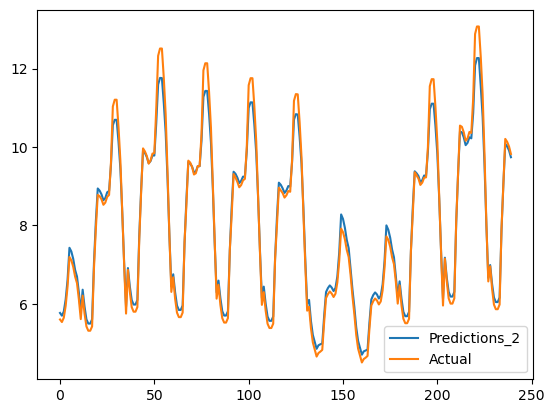

In [12]:
s=24*(200-10)
e=24*200
test_predictions_1 = model_1(te_in.float())
test_predictions_2 = model_2(te_in.float())
#plt.plot(test_predictions_1.detach()[s:e],label = "Predictions_1")
plt.plot(test_predictions_2.detach()[s:e],label = "Predictions_2")
plt.plot(te_out[s:e],label = "Actual")
plt.legend()